# predictive modeling

To make the reload of PSI tables faster, I've done the following in the previous `05-Navy_predictive-model.ipynb` notebook:

```python
# Dump PSI tables for faster reload in the future
for as_type in data_files:
    for measure_type in ('txr', 'jct'):
        print(as_type, measure_type)
        metaloader._count_tables[as_type][measure_type].data.applymap(lambda x: x.psi).round(3).\
        to_csv(f"./{DATA_VER}/compiled/{measure_type}_{as_type}.PSItable.txt", sep="\t")
```

In [1]:
from datetime import datetime; print("START:", datetime.now())
import socket; print("Simons Foundation, Rusty HPC,", socket.gethostname())

START: 2022-07-02 17:07:30.748482
Simons Foundation, Rusty HPC, worker2055


In [2]:
%cd ..

/mnt/ceph/users/zzhang/CHARM-AlternativeSplicing


## 1. Read in data

In [3]:
# import everything we will need from jemm
from jemm.junction import JunctionCountTable
from jemm.transcript import TranscriptMeasureTable
from jemm.model import Jemm, JemmLinearRegression
from jemm.plots import facet_boxplot, beta_barplot
from jemm.covariate import Contrasts, Covariate
from jemm.meta_loader import MetaLoader
from jemm.covariate import Contrasts, Covariate

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold

import pickle
import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm
import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex', 'ieee'])
import scipy

DATA_VER = 'data-V7'
PCS_TO_INCL = '0,6'
USE_RE = True

CLFDIR = '%s/das_classifier2' % DATA_VER
os.makedirs(CLFDIR, exist_ok=True)

%run ./notebooks/navy_utils.V7.py $DATA_VER $PCS_TO_INCL $USE_RE

navy_utils.py data-V7 ['PC0', 'PC6'] True


## 1.1 Read splicing data

In [4]:
data_files = {
    'SE': {
        'jct': None, #'./%s/compiled/jct_SE.PSItable.txt' % DATA_VER,
        'txr': './%s/compiled/txr_SE.PSItable.txt'% DATA_VER
    }, 
    'A5SS': {
        'jct': None, #'./%s/compiled/jct_A5SS.PSItable.txt'% DATA_VER,
        'txr': './%s/compiled/txr_A5SS.PSItable.txt'% DATA_VER
    }, 
    'A3SS': {
        'jct': None, #'./%s/compiled/jct_A3SS.PSItable.txt'% DATA_VER,
        'txr': './%s/compiled/txr_A3SS.PSItable.txt'% DATA_VER
    }, 
    'RI': {
        'jct': None, #'./%s/compiled/jct_RI.PSItable.txt'% DATA_VER,
        'txr': './%s/compiled/txr_RI.PSItable.txt'% DATA_VER
    }
}

reg_tables = {
    'SE': './%s/joint_SE/joint.SE.reg_table.tsv'% DATA_VER,
    'A5SS': './%s/joint_A5SS/joint.A5SS.reg_table.tsv'% DATA_VER,
    'A3SS': './%s/joint_A3SS/joint.A3SS.reg_table.tsv'% DATA_VER,
    'RI': './%s/joint_RI/joint.RI.reg_table.tsv'% DATA_VER
}


contrast_cols = ['final@Pre', 'final@First', 'final@Mid', 'final@Post', 
                 'final@False Negative','final@Immune', 'final@Reinfection',
                 'final@Asymptomatic', 
                 'final@Exposed', 
                 'final@Mild',
                 'final@Moderate']

metaloader = MetaLoader(covs, data_files, reg_tables,
                        jem_type='lmm' if USE_RE else 'lm',
                        jem_kwargs={'diff_intercept_by_measure':True,
                            'group_varname': 'pid'})

loading SE..
loaded n=0 jct, n=(47847, 1444) txr; took 62.196 sec


/mnt/ceph/users/zzhang/RnaSplicingHub/jemm/jemm/model.py:176: UserWarning: Input covariate matrix has condition number = 39865.3750103749 > 100, indicating the presence of co-linearality; optimization might be unstable.
  _ = self._check_covariate_condition()


get model took 0.218 sec
load reg table took 44.462 sec
loading A5SS..
loaded n=0 jct, n=(17687, 1444) txr; took 23.057 sec
get model took 0.068 sec
load reg table took 13.119 sec
loading A3SS..
loaded n=0 jct, n=(19353, 1444) txr; took 25.304 sec
get model took 0.073 sec
load reg table took 14.363 sec
loading RI..
loaded n=0 jct, n=(7345, 1444) txr; took 9.863 sec
get model took 0.034 sec
load reg table took 5.546 sec


In [5]:
duke_folder = 'duke_whole_blood'
duke_data_files = {
    'SE': {
        'jct': './data-V7/%s/jct_SE.pkl' % duke_folder,
        'txr': './data-V7/%s/txr_SE.pkl' % duke_folder
    }, 
    'A5SS': {
        'jct': './data-V7/%s/jct_A5SS.pkl' % duke_folder,
        'txr': './data-V7/%s/txr_A5SS.pkl' % duke_folder
    }, 
    'A3SS': {
        'jct': './data-V7/%s/jct_A3SS.pkl' % duke_folder,
        'txr': './data-V7/%s/txr_A3SS.pkl' % duke_folder
    }, 
    'RI': {
        'jct': './data-V7/%s/jct_RI.pkl' % duke_folder,
        'txr': './data-V7/%s/txr_RI.pkl' % duke_folder
    }
}

duke_contrasts = Contrasts(name="Pathogen", levels=[
    'healthy', 
    'COVID-19'
])
duke_covs_wb = Covariate(fp="./data-V7/%s/meta_full.tsv" %duke_folder, sep="\t", 
                 index_col=0,
                 contrasts=duke_contrasts,
                 main_effects=['Pathogen', 'gender', 'days_since_onset'],
                 verbose=True
             )
duke_wb_metaloader = MetaLoader(duke_covs_wb, duke_data_files,
                       jem_kwargs={'diff_intercept_by_measure':True})

loading SE..
loaded n=(41922, 66) jct, n=(47847, 66) txr; took 23.720 sec
get model took 0.095 sec
loading A5SS..
loaded n=(3822, 66) jct, n=(17687, 66) txr; took 6.485 sec
get model took 0.022 sec
loading A3SS..
loaded n=(5711, 66) jct, n=(19353, 66) txr; took 8.344 sec
get model took 0.025 sec
loading RI..
loaded n=(4593, 66) jct, n=(7345, 66) txr; took 3.460 sec
get model took 0.013 sec


## 1.2 Read gene expression

In [6]:
df1 = pd.read_table("./%s/CHARM.TPM_matrix.geneSymbol.txt"%CLFDIR, index_col=0)
df1 = df1[[x for x in df1.columns if x in covs.meta.index]]
df1 = df1[~df1.index.duplicated(keep='first')]

duke_folder = 'duke_whole_blood'

duke_contrasts = Contrasts(name="Pathogen", levels=[
    'healthy', 
    'COVID-19'
])
duke_covs_wb = Covariate(fp="./data-V7/%s/meta_full.tsv" %duke_folder, sep="\t", 
                 index_col=0,
                 contrasts=duke_contrasts,
                 main_effects=['Pathogen', 'gender', 'days_since_onset'],
                 verbose=True
             )
df2 = pd.read_table("./%s/DUKE.TPM_matrix.geneSymbol.txt"%CLFDIR, index_col=0)
df2 = df2[~df2.index.duplicated(keep='first')]
common_genes = set([g for g in df2.index if g in df1.index])
df1 = df1.loc[common_genes]
df2 = df2.loc[common_genes]

print(df1.shape)
print(df2.shape)

(51825, 1176)
(51825, 66)


## 1.3 Helper for featurizing individuals

In [7]:
def get_expr_df(tot_gids, df, dropnan=True):
    expr_df = df.loc[tot_gids]
    expr_df = expr_df.transpose()
    if dropnan is True:
        expr_df = expr_df.dropna(axis=1)    
    return expr_df

In [8]:
def get_psi_df(tot_eids, metaloader, use_jct=True, use_txr=True, dropnan=True, min_eid_cov=0):
    psi_df_list = []
    for as_type in ['SE', 'A5SS', 'A3SS', 'RI']:
        if not as_type in tot_eids:
            continue
        eids = [e for e in tot_eids[as_type]]
        if use_jct:
            jct = metaloader.data[as_type].junction_measure.reindex(eids).applymap(lambda x: x if type(x) is float else x.psi)
            jct.rename(index=lambda x: 'jct:%s:'%as_type + x, inplace=True)
            psi_df_list.append(jct.transpose())
        if use_txr:
            txr = metaloader.data[as_type].transcript_measure.reindex(eids).applymap(lambda x: x if type(x) is float else x.psi)
            txr.rename(index=lambda x: 'txr:%s:'%as_type + x, inplace=True)
            psi_df_list.append(txr.transpose())
    psi_df = pd.concat(psi_df_list, axis=1)
    if dropnan is True:
        psi_df = psi_df.dropna(axis=1)
    if min_eid_cov > 0:
        eid_cov = psi_df.apply(lambda x: np.std(x)/(np.mean(x)+0.01), axis=0)
        psi_df = psi_df.loc[:, eid_cov>min_eid_cov]
    
    return psi_df

## 2. Extract the CHARM samples PSI

In [9]:
# get total pre samples with RNA-seq (in sample index)
total_pre = covs.meta.loc[covs.meta.final=='Pre']
total_pre=set(list([x for x in metaloader.data['SE'].sample_index if x in total_pre.index]))
pre_subject_ids = list(set([x.split('-')[0] for x in total_pre]))
pre_subject_samps = list(set([(y, covs.meta.loc[y, 'final'], covs.meta.loc[y, 'Sex']) for x in pre_subject_ids
                     for y in metaloader.data['SE'].sample_index if y.split('-')[0] == x]))

# up to here is a list of (sid, final), where the individual has Pre at one tp
pre_df = pd.DataFrame(pre_subject_samps, columns=['ID', 'final', 'Sex'])

# adding a preceding P is necessary as to not confuse seaborn..
pre_df['individual'] = ["P"+x.split('-')[0] for x in pre_df['ID']]
pre_df['tp'] = [int(x.split('-')[1].lstrip('T')) for x in pre_df['ID']]
pre_df.index = pre_df['ID']
print(pre_df.shape)

# this is a df of controls that with Pre
pre_df.head()

(235, 5)


,ID,final,Sex,individual,tp
ID,,,,,
20_0228-T49,20_0228-T49,Mid,M,P20_0228,49
20_0254-T28,20_0254-T28,Pre,F,P20_0254,28
20_0182-T56,20_0182-T56,Post,F,P20_0182,56
20_0163-T39,20_0163-T39,First,F,P20_0163,39
20_0165-T00,20_0165-T00,Control,F,P20_0165,0


In [10]:
# get total first/first-mid/mid samples with RNA-seq (in sample index)
total_infect = covs.meta.loc[covs.meta.final.isin(['Control','Pre', 'First', 'Mid'])]

# get the ones with RNA-seq
total_infect = [x for x in metaloader.data['SE'].sample_index if x in total_infect.index]

# strip the subject ids
inft_subject_ids = list(set([x.split('-')[0] for x in total_infect]))

# dummy join
inft_subject_samps = [(y, covs.meta.loc[y, 'final'], covs.meta.loc[y, 'Sex']) for x in inft_subject_ids
                     for y in metaloader.data['SE'].sample_index \
                     if y.split('-')[0] == x and y.split('-')[0]]

# up to here is a list of (sid, final, sex)
inft_df = pd.DataFrame(inft_subject_samps, columns=['ID', 'final', 'Sex'])
inft_df.drop_duplicates(inplace=True)

# adding a preceding P is necessary as to not confuse seaborn..
inft_df['individual'] = ["P"+x.split('-')[0] for x in inft_df['ID']]
inft_df['tp'] = [int(x.split('-')[1].lstrip('T')) for x in inft_df['ID']]
inft_df.index = inft_df['ID']
inft_df = inft_df.loc[inft_df.final.isin(['Control', 'Pre', 'First', 'Mid'])]
print(inft_df.shape)
infect_train_df = inft_df.loc[~inft_df['ID'].isin(pre_df.loc[pre_df['final'].isin(['Control'])]['ID'])]

inft_df['final'].unique()


(580, 5)


array(['Control', 'First', 'Mid', 'Pre'], dtype=object)

# 3. Run DEG statistical tests

In [11]:
ctrl_sids = covs.meta.query("final=='Control'")
first_sids = covs.meta.query("final=='First'")
res_df = {'gene':[], 'ctrl_mean':[], 'first_mean':[], 'log2fc':[], 'mw_pval':[], 't_pval':[]}
for _, gene_row in tqdm(df1.iterrows(), total=df1.shape[0]):
    try:
        mw = ss.mannwhitneyu(gene_row[ctrl_sids.index], gene_row[first_sids.index]).pvalue
    except ValueError:
        mw = 1
    pseudo_cnt = 0.1
    t = ss.ttest_ind(np.log2(gene_row[ctrl_sids.index]+pseudo_cnt), np.log2(gene_row[first_sids.index]+pseudo_cnt)).pvalue
    res_df['gene'].append(gene_row.name)
    res_df['ctrl_mean'].append(gene_row[ctrl_sids.index].mean())
    res_df['first_mean'].append(gene_row[first_sids.index].mean())
    res_df['log2fc'].append( np.abs(np.log2(res_df['ctrl_mean'][-1]+pseudo_cnt) - 
                                    np.log2(res_df['first_mean'][-1]+pseudo_cnt)) )    
    res_df['mw_pval'].append(mw)
    res_df['t_pval'].append(t)


100%|██████████| 51825/51825 [02:37<00:00, 329.66it/s]


In [12]:
from jemm.utils import fdr_bh

deg_df = pd.DataFrame(res_df)
deg_df['mw_fdr'] = fdr_bh(deg_df['mw_pval'])
deg_df['t_fdr'] = fdr_bh(deg_df['t_pval'])
deg_df['mw_bonf'] = deg_df['mw_pval']*deg_df.shape[0]
deg_df['t_bonf'] = deg_df['t_pval']*deg_df.shape[0]
deg_df.index = deg_df['gene']

## 4. Build Classifier and Cross-cohort Duke data prediction

In [13]:
configs = {
    'FirstExon1e-8-FirstSamps': {
        'feature_eids': {
            as_type:[ e 
                for e in sorted(metaloader.data[as_type].stats_tests)
                if metaloader.data[as_type].stats_tests[e].loc['final@First', 'qvals']<1e-8
        ]
        for as_type in metaloader.data},
        'train_conds': "final=='Control' or final=='First'",
        'model_type': 'DAS',
    },
    'FirstExon1e-6-FirstSamps': {
        'feature_eids': {
            as_type:[ e 
                for e in sorted(metaloader.data[as_type].stats_tests)
                if metaloader.data[as_type].stats_tests[e].loc['final@First', 'qvals']<1e-6
        ]
        for as_type in metaloader.data},
        'train_conds': "final=='Control' or final=='First'",
        'model_type': 'DAS',
    },
    
    'FirstExon0.0001-FirstSamps': {
        'feature_eids': {
            as_type:[ e 
                for e in sorted(metaloader.data[as_type].stats_tests)
                if metaloader.data[as_type].stats_tests[e].loc['final@First', 'qvals']<0.0001
        ]
        for as_type in metaloader.data},
        'train_conds': "final=='Control' or final=='First'",
        'model_type': 'DAS',
    },

    'FirstExon0.001-FirstSamps': {
        'feature_eids': {
            as_type:[ e 
                for e in sorted(metaloader.data[as_type].stats_tests)
                if metaloader.data[as_type].stats_tests[e].loc['final@First', 'qvals']<0.001
        ]
        for as_type in metaloader.data},
        'train_conds': "final=='Control' or final=='First'",
        'model_type': 'DAS',
    },
    
    'FirstExon0.005-FirstSamps': {
        'feature_eids': {
            as_type:[ e 
                for e in sorted(metaloader.data[as_type].stats_tests.keys())
                if metaloader.data[as_type].stats_tests[e].loc['final@First', 'qvals']<0.005
        ]
        for as_type in metaloader.data},
        'train_conds': "final=='Control' or final=='First'",
        'model_type': 'DAS',
    },
    
    'FirstExon0.01-FirstSamps': {
        'feature_eids': {
            as_type:[ e 
                for e in sorted(metaloader.data[as_type].stats_tests.keys())
                if metaloader.data[as_type].stats_tests[e].loc['final@First', 'qvals']<0.01
        ]
        for as_type in metaloader.data},
        'train_conds': "final=='Control' or final=='First'",
        'model_type': 'DAS',
    },
    
    'FirstExon0.025-FirstSamps': {
        'feature_eids': {
            as_type:[ e 
                for e in sorted(metaloader.data[as_type].stats_tests.keys())
                if metaloader.data[as_type].stats_tests[e].loc['final@First', 'qvals']<0.025
        ]
        for as_type in metaloader.data},
        'train_conds': "final=='Control' or final=='First'",
        'model_type': 'DAS',
    },
    
    
    'FirstExon0.05-FirstSamps': {
        'feature_eids': {
            as_type:[ e 
                for e in sorted(metaloader.data[as_type].stats_tests)
                if metaloader.data[as_type].stats_tests[e].loc['final@First', 'qvals']<0.05
        ]
        for as_type in metaloader.data},
        'train_conds': "final=='Control' or final=='First'",
        'model_type': 'DAS',
    },
    
}


In [14]:
# Add DEG features

configs.update({
    f'CHARM-top{n_top}': {
        'feature_eids': deg_df.sort_values('t_fdr').head(n_top).index,
        'train_conds': "final=='Control' or final=='First'",
        'model_type': 'DEG',
    }
    for n_top in (100, 200, 300, 400, 500, 600, 700, 800, 900)

})

We skipped the splicing type specific features, because except SE, other types have too few numbers of candidate events:

```python
# splicing type specific features
stats_sheet = {as_type: pd.DataFrame({'eid': [x for x in metaloader.data[as_type].stats_tests],
                                      'qvals': [metaloader.data[as_type].stats_tests[x].loc['final@First', 'qvals'] for x in metaloader.data[as_type].stats_tests]
                                     })
    for as_type in ('SE', 'A5SS', 'A3SS', 'RI')
}
configs.update({
    f'{as_type}-top{n_top}': {
        'feature_eids': {as_type: [ e 
                for e in stats_sheet[as_type].query('qvals<0.05').sort_values('qvals', ascending=True).head(n_top).eid ] },
        'train_conds': "final=='Control' or final=='First'",
        'model_type': as_type,
    }
    for as_type in ('SE', 'A5SS', 'A3SS', 'RI')
    for n_top in (100, 300, 500, 700, 1000)
})
```

In [15]:
def build_classifier(feature_eids, train_conds, add_sex_term=False, model_type='DAS'):
    stats = {}
    if model_type == 'DEG':
        feature_psi_df = get_expr_df(feature_eids, df=df1)
    else:
        feature_psi_df = get_psi_df(feature_eids, metaloader, use_jct=False, use_txr=True)
    stats['feature_psi.shape'] = feature_psi_df.shape
    train_df = infect_train_df.query(train_conds)

    stats['train_df.shape'] = train_df.shape
    stats['feature_df.columns'] = feature_psi_df.columns
    X_train = feature_psi_df.loc[train_df.ID].to_numpy()
    y_train = np.array([1 if train_df['final'][i]!='Control' else 0 for i in range(train_df.shape[0])])
    if add_sex_term is True:
        X_train = np.concatenate([
            np.expand_dims(infect_train_df.query(train_conds)['Sex']=="M", -1),
            X_train
        ], axis=1)
    prop_y = np.mean(y_train)
    stats['clf.class_weight'] = (1-prop_y)/prop_y 
    clf = LogisticRegression(
        class_weight={0:1, 1: (1-prop_y)/prop_y},
        penalty='l2',
        #solver='liblinear', 
        solver='sag', ## turns out the solver and its max_iter are very important
        max_iter=10000, 
        random_state=777,
        #probability=True
    )
    cvx = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
    y_pred = cross_val_predict(clf, X_train, y_train, cv=cvx, method='predict_proba', n_jobs=1)
    clf.fit(X_train, y_train)
    pred_train = clf.predict_proba(X_train)[:, 1]
    train_df['first_clf_pred'] = pred_train
    stats['clf.coef'] = pd.Series(clf.coef_[0], index=feature_psi_df.columns if add_sex_term is False else \
                                 ['is_male'] + feature_psi_df.columns.to_list())
    stats['y_train.cv_pred'] = y_pred
    return clf, train_df, feature_psi_df, stats

In [16]:
# Use Duke study with whole-blood samples
duke_metaloader = duke_wb_metaloader
duke_covs = duke_covs_wb

def build_tester(trained_clf, feature_eids, feature_df_columns, add_sex_term=False, model_type='DAS'):
    stats = {}
    if model_type=='DEG':
        duke_psi_df = get_expr_df(feature_eids, df=df2, dropnan=False)
    else:
        duke_psi_df = get_psi_df(feature_eids, duke_metaloader, dropnan=False)
    # re-order the x matrix so it matched the beta
    duke_psi_df = duke_psi_df.loc[:, feature_df_columns]
    duke_psi_df.fillna(duke_psi_df.mean(skipna=True), inplace=True)
    duke_psi_df.fillna(0.5, inplace=True)
    stats['n_features'] = duke_psi_df.shape[1]
    duke_X = duke_psi_df.to_numpy()
    if add_sex_term is True:
        duke_X = np.concatenate([
            np.expand_dims(duke_covs.covariate['gender@MALE'].to_numpy(), -1),
            duke_X
        ], axis=1)
    duke_y = np.array(
        # meta.csv
        #[1 if duke_covs.meta.loc[i, 'cond'][i]=='COVID' else 0 for i in duke_metaloader.junction_measure.columns]
        # meta_full.tsv
        [1 if duke_covs.meta.loc[i, 'Pathogen']=='COVID-19' else 0 for i in duke_metaloader.data['SE'].junction_measure.columns]
    )
    duke_pred = trained_clf.predict_proba(duke_X)[:,1]
    stats['test_aupr'] = average_precision_score(duke_y, duke_pred)
    stats['test_auc'] = roc_auc_score(duke_y, duke_pred)
    return duke_y, duke_pred, duke_psi_df, stats

## 4.1 Evaluate different model configs (no. feats, das vs deg)

In [17]:
reload = True
if reload is False:
    model_evals = {}
    clfs = {}
    train_dfs = {}
    duke_preds = {}
    train_stats = {}
    train_psi_dfs = {}
    duke_psi_dfs = {}
    for model_id in configs:
        print(model_id)
        clf, train_df, train_psi_df, train_stat = build_classifier(
            **configs[model_id])
        duke_y, duke_pred, duke_psi_df, test_stat = build_tester(
            trained_clf=clf,
            feature_eids=configs[model_id]['feature_eids'], 
            feature_df_columns=train_stat['feature_df.columns'],
            add_sex_term=configs[model_id].get('add_sex_term', False),
            model_type=configs[model_id].get('model_type', 'DAS')
        )
        model_evals[model_id] = test_stat
        model_evals[model_id]['model_type'] = configs[model_id]['model_type']
        clfs[model_id] = clf
        train_dfs[model_id] = train_df
        duke_preds[model_id] = duke_pred
        train_stats[model_id] = train_stat
        train_psi_dfs[model_id] = train_psi_df
        duke_psi_dfs[model_id] = duke_psi_df

    model_eval_df = pd.DataFrame.from_dict(model_evals, orient='index')
    model_eval_df.rename(columns={
        'n_features': 'No. Features', 
        'test_aupr': 'Test AUPR', 
        'test_auc': 'Test AUROC', 
        'feature_qval': 'FDR cutoff'}, inplace=True)
    model_eval_df['PSI model'] = ['linear' if x.endswith('LM') else 'mixed' for x in model_eval_df.index]
    model_eval_df.to_csv("%s/performance.tsv" % CLFDIR, sep="\t", index=True)

    pickle.dump((clfs, model_eval_df, train_stats, train_psi_dfs, train_dfs, duke_psi_dfs, duke_preds, duke_y), open('%s/predictive_model_dict.pkl' % CLFDIR, 'wb'))
    
    print('trained model from scratch')
    print(model_eval_df)
else:
    print('skipped training from scratch')

skipped training from scratch


In [18]:
if reload is True:
    (clfs, model_eval_df, train_stats, train_psi_dfs, train_dfs, duke_psi_dfs, duke_preds, duke_y) = pickle.load(
        open('%s/predictive_model_dict.pkl' % CLFDIR, 'rb'))
    print('reloaded previously trained model')
else:
    print('skipped reloading')

reloaded previously trained model


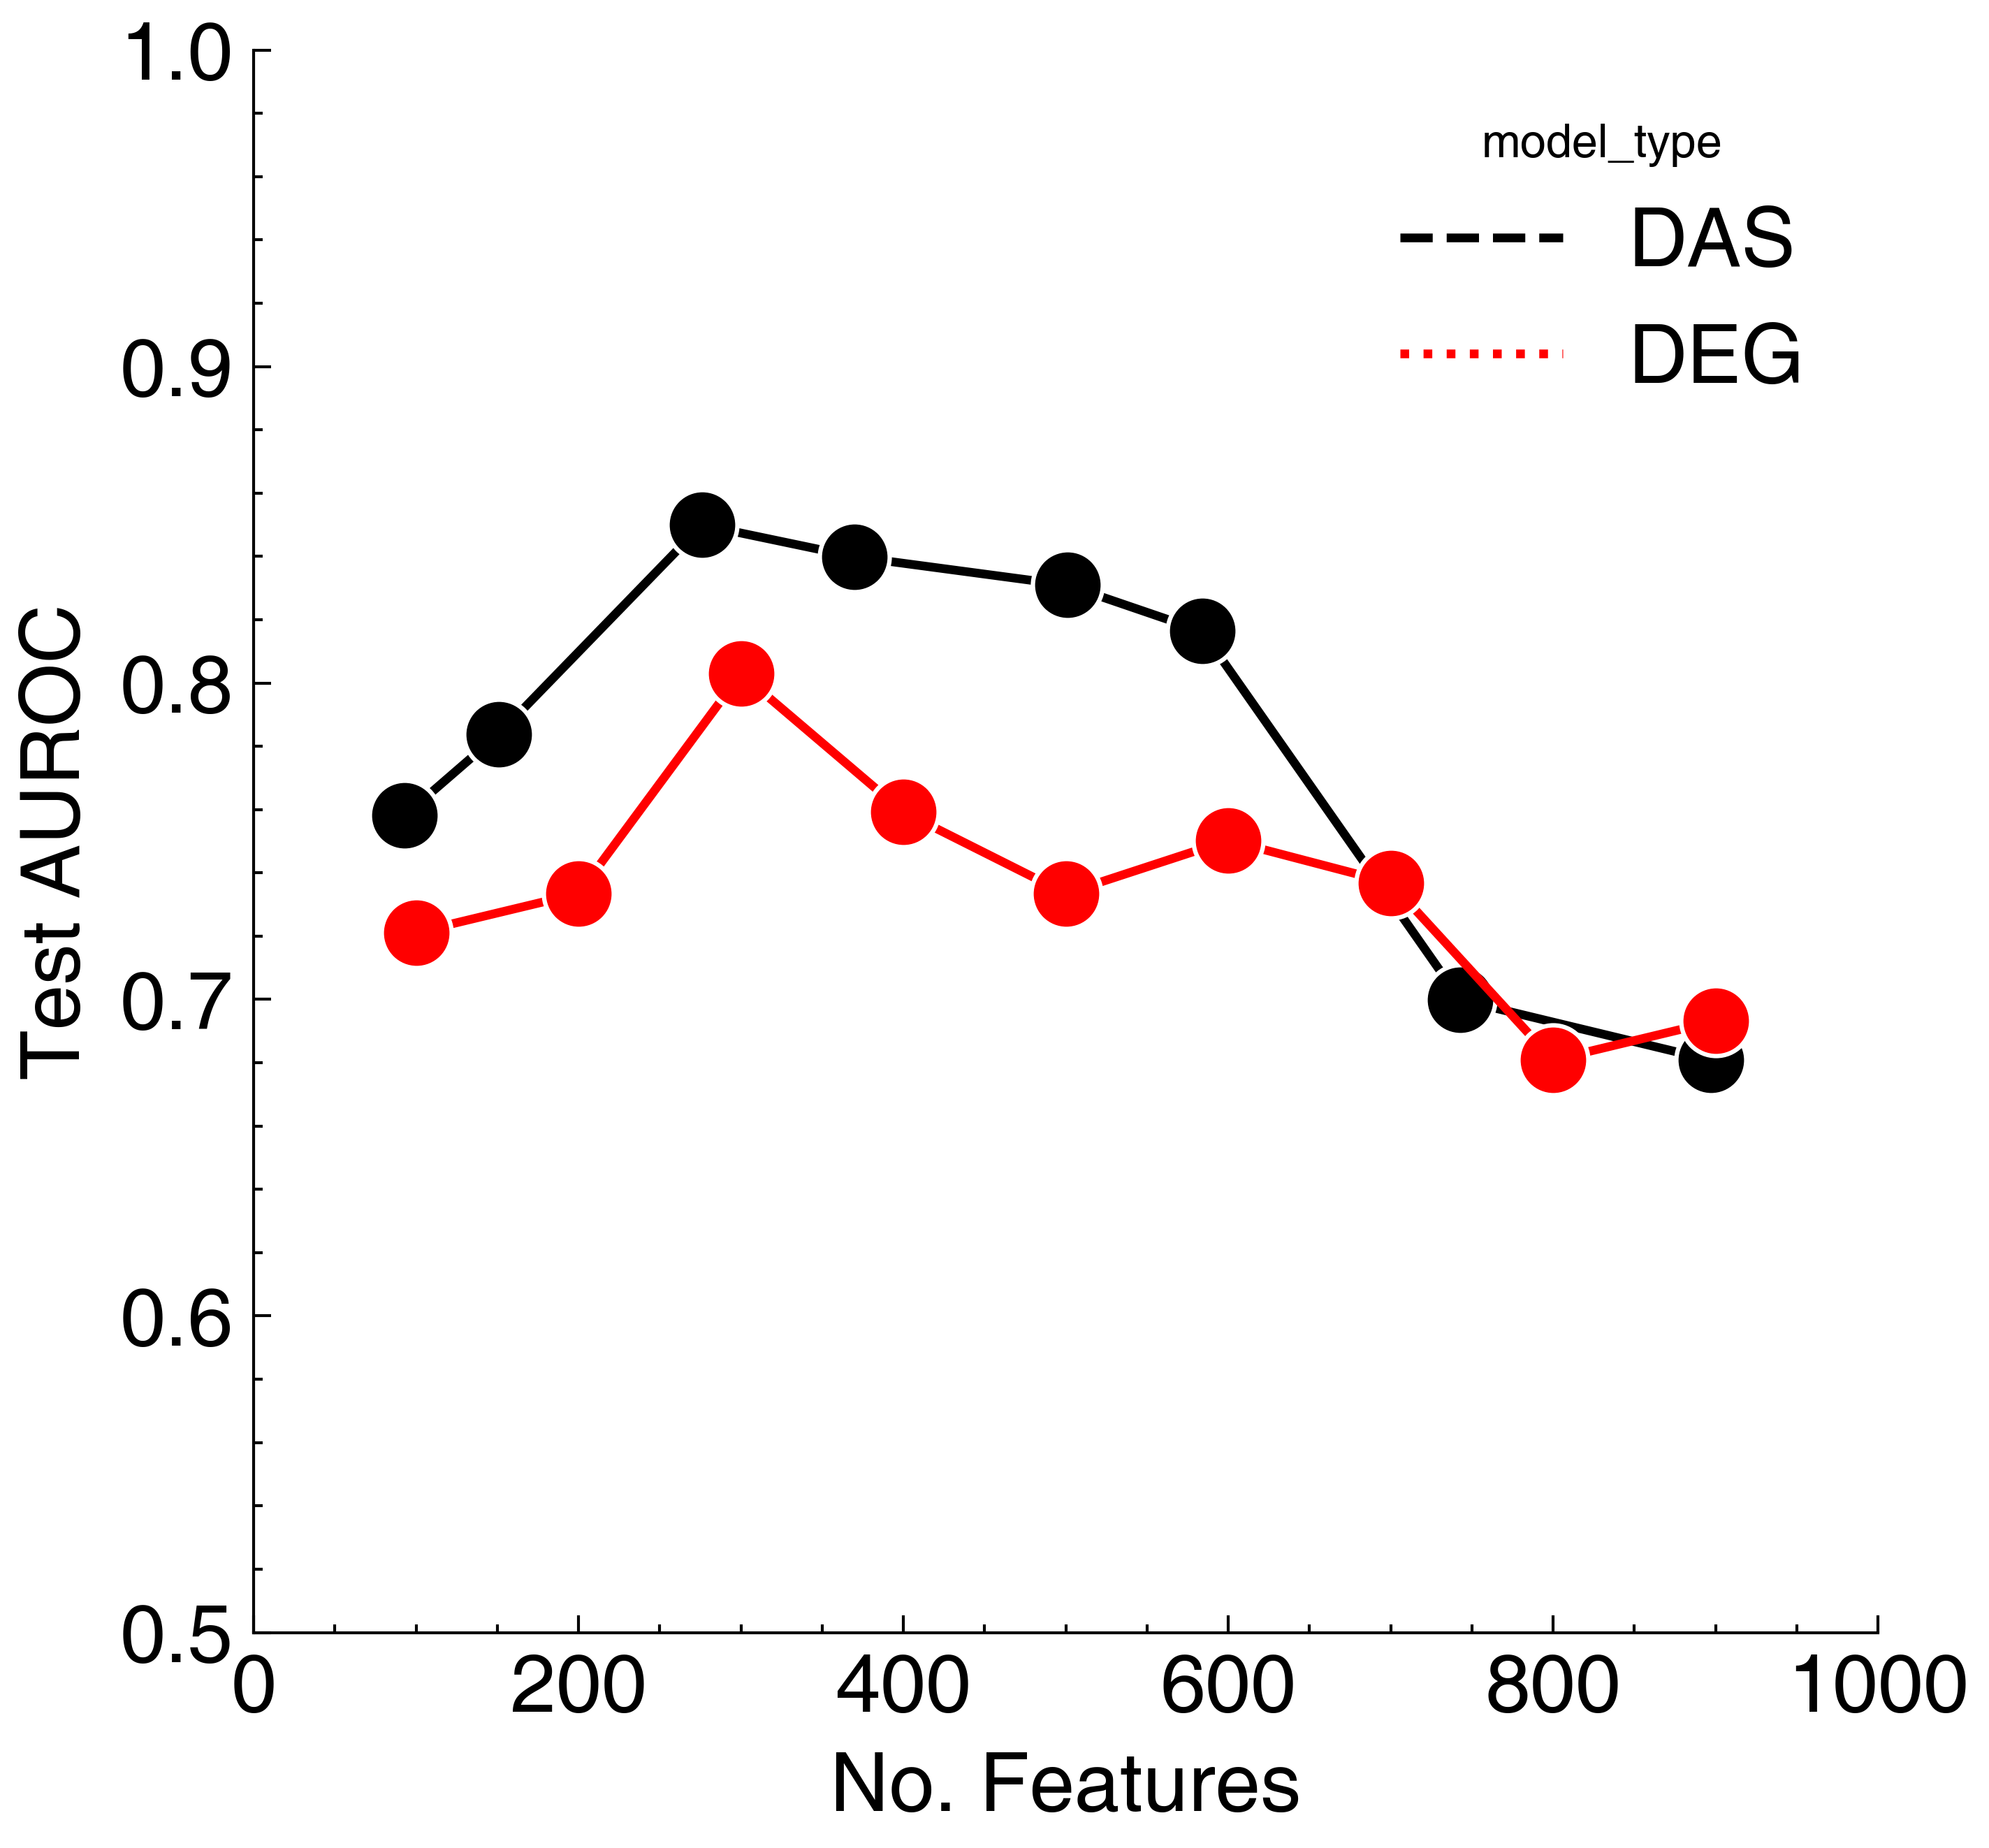

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.lineplot(x='No. Features', y='Test AUROC', hue='model_type', marker='o', ls='-', markersize=12, data=model_eval_df)
#ax.set_title('Duke Cohort prediction accuracy at varying FDR cutoffs')
ax.set_ylim(0.5, 1.0)
ax.set_xlim(0, 1000)
fig.savefig("%s/01-performance.pdf" % CLFDIR)

## 4.2 Cross-validation predict for Control samples

In [20]:
best_clf_id = model_eval_df.index[model_eval_df['Test AUROC'].argmax()]
duke_pred = duke_preds[best_clf_id]
best_clf = clfs[best_clf_id]
print("Best model = %s, AUC=%.3f" % (best_clf_id, model_eval_df['Test AUROC'].max()))

Best model = FirstExon0.0001-FirstSamps, AUC=0.850


In [21]:
# Call external Rscript for AUROC plot
pd.DataFrame({'duke_pred':duke_pred, 'duke_y':duke_y}).to_csv("%s/duke_pred.data.txt"%CLFDIR, sep="\t")
cmd = "Rscript plot_AUROC.R %s" % CLFDIR
print(cmd)
os.system(cmd)

Rscript plot_AUROC.R data-V7/das_classifier2


0

In [22]:
# get cv avg and std AUC for best model
feature_eids = {
    as_type:[ e 
        for e in sorted(metaloader.data[as_type].stats_tests)
        if metaloader.data[as_type].stats_tests[e].loc['final@First', 'qvals']<0.001
            ]
    for as_type in metaloader.data
}
train_conds = "final=='Control' or final=='First'"
feature_psi_df = get_psi_df(feature_eids, metaloader, use_jct=False, use_txr=True)
train_df = infect_train_df.query(train_conds)
X_train = feature_psi_df.loc[train_df.ID].to_numpy()
y_train = np.array([1 if train_df['final'][i]!='Control' else 0 for i in range(train_df.shape[0])])
cvx = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
scores = cross_val_score(best_clf, X_train, y_train, cv=cvx, n_jobs=1)
print('acc, mean=', np.mean(scores), 'std=', np.std(scores))
scores = cross_val_score(best_clf, X_train, y_train, scoring='roc_auc', cv=cvx, n_jobs=1)
print('auc, mean=', np.mean(scores), 'std=', np.std(scores))


acc, mean= 0.9183673469387756 std= 0.0387217672673679
auc, mean= 0.9231452581032412 std= 0.09122696958907893


In [23]:
best_train_df = train_dfs[best_clf_id]
best_train_df['cv_pred'] = train_stats[best_clf_id]['y_train.cv_pred'][:, 1]

ctrl_w_long = []
for pid in best_train_df.query('final=="Control"')['individual'].unique():
    this = best_train_df.query('final=="Control" and individual=="%s"' % pid)
    if this.shape[0] == 1:
        continue
    ctrl_w_long.append(pid)

/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


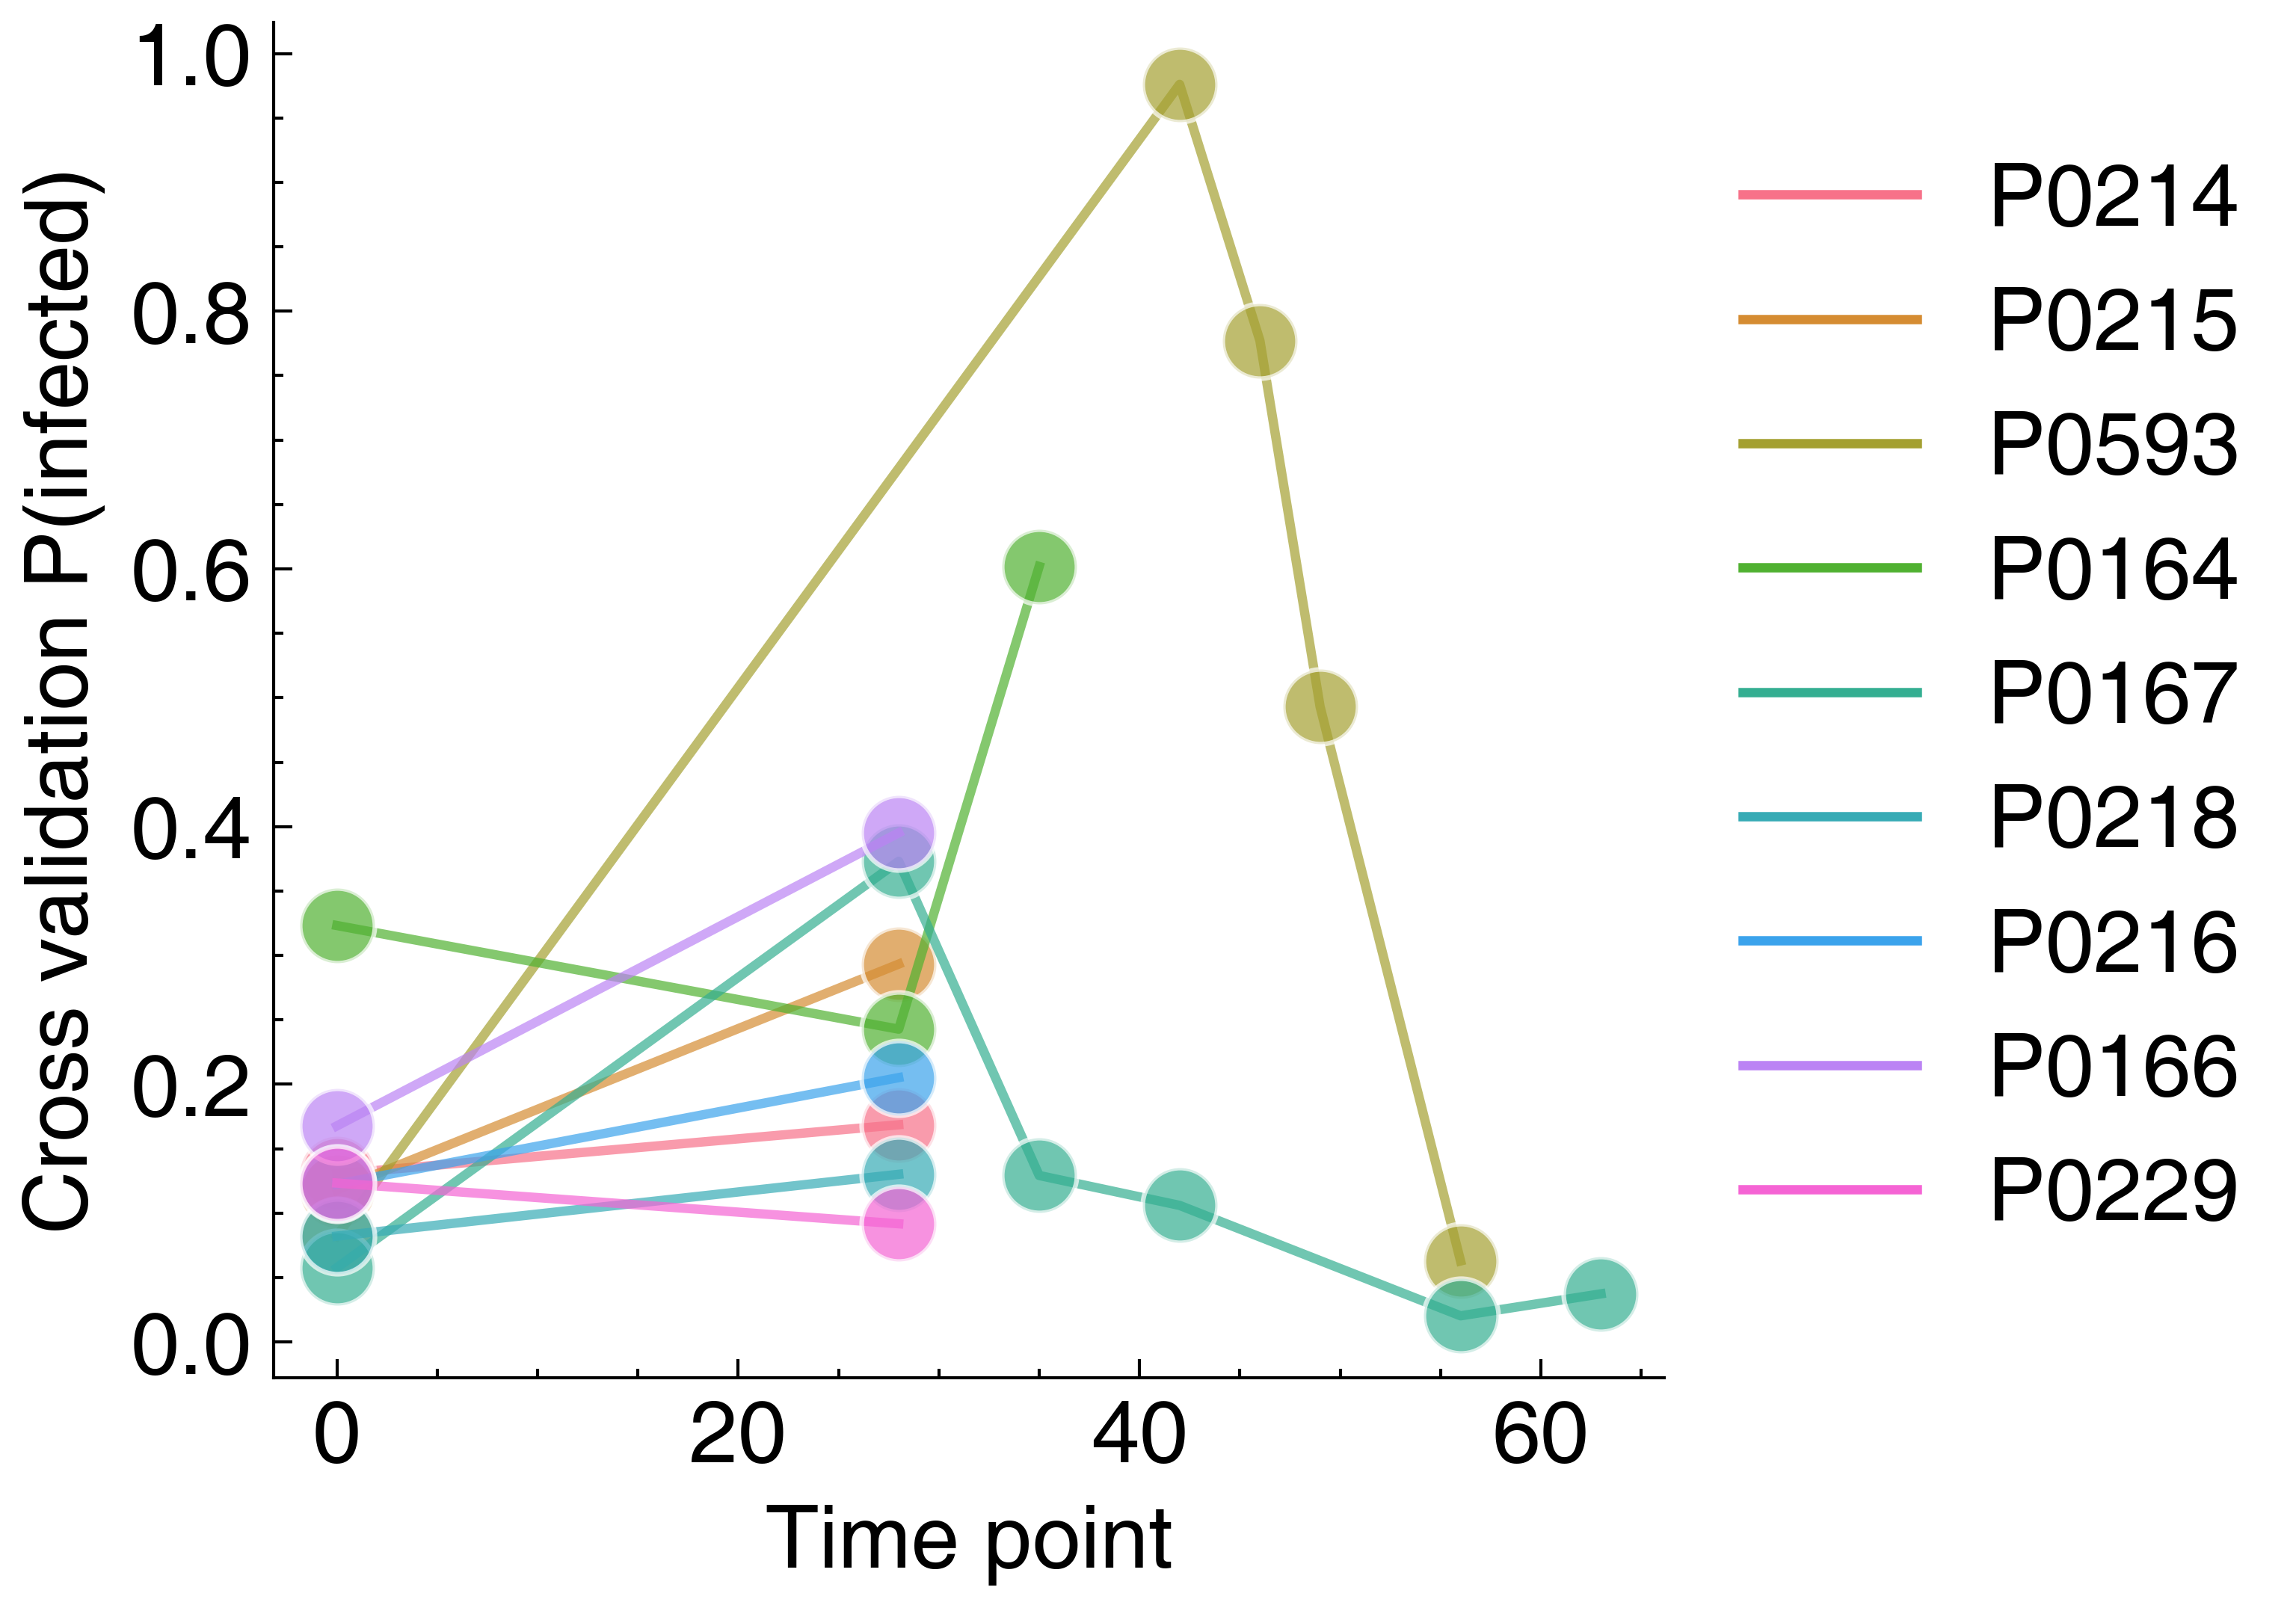

In [24]:
plot_df = best_train_df.loc[best_train_df['individual'].isin(ctrl_w_long)]
plot_df['individual'] = ['P%s'%x.split('_')[1] for x in plot_df['individual']]
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.lineplot(x='tp', y='cv_pred', hue='individual', marker='o', ls='-',
             markersize=12, data=plot_df, alpha=0.7,
             ax=ax)
ax.set_ylabel('Cross validation P(infected)')
ax.set_xlabel('Time point')
handles, labels = ax.get_legend_handles_labels()
for h in handles: h.set_linestyle("-")
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig('%s/02-train_cv_ctrl_long.pdf' % CLFDIR)

In [25]:
tp_df = {}
for pid in plot_df['individual'].unique():
    this = plot_df.query('individual == "%s"' % pid).sort_values('tp', ascending=True)
    tp_df[pid] = {
        'before_train': this.head(1)['cv_pred'].values[0],
        'amid_train_28': this.loc[this['tp']==28, 'cv_pred'].values[0] if (this['tp']==28).sum()>0 else np.nan,
        'after_train':  this.tail(1)['cv_pred'].values[0],
    }
    
ctrl_tp_df = pd.DataFrame(tp_df).transpose()
ctrl_tp_df['diff2'] = ctrl_tp_df['after_train'] - ctrl_tp_df['before_train']
ctrl_tp_df['diff1'] = ctrl_tp_df['amid_train_28'] - ctrl_tp_df['before_train']

ctrl_tp_df_ = ctrl_tp_df.append({'diff1': 1, 'diff2':1}, ignore_index=True)
ctrl_tp_df_ = ctrl_tp_df_.append({'diff1': -1, 'diff2':-1}, ignore_index=True)


/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


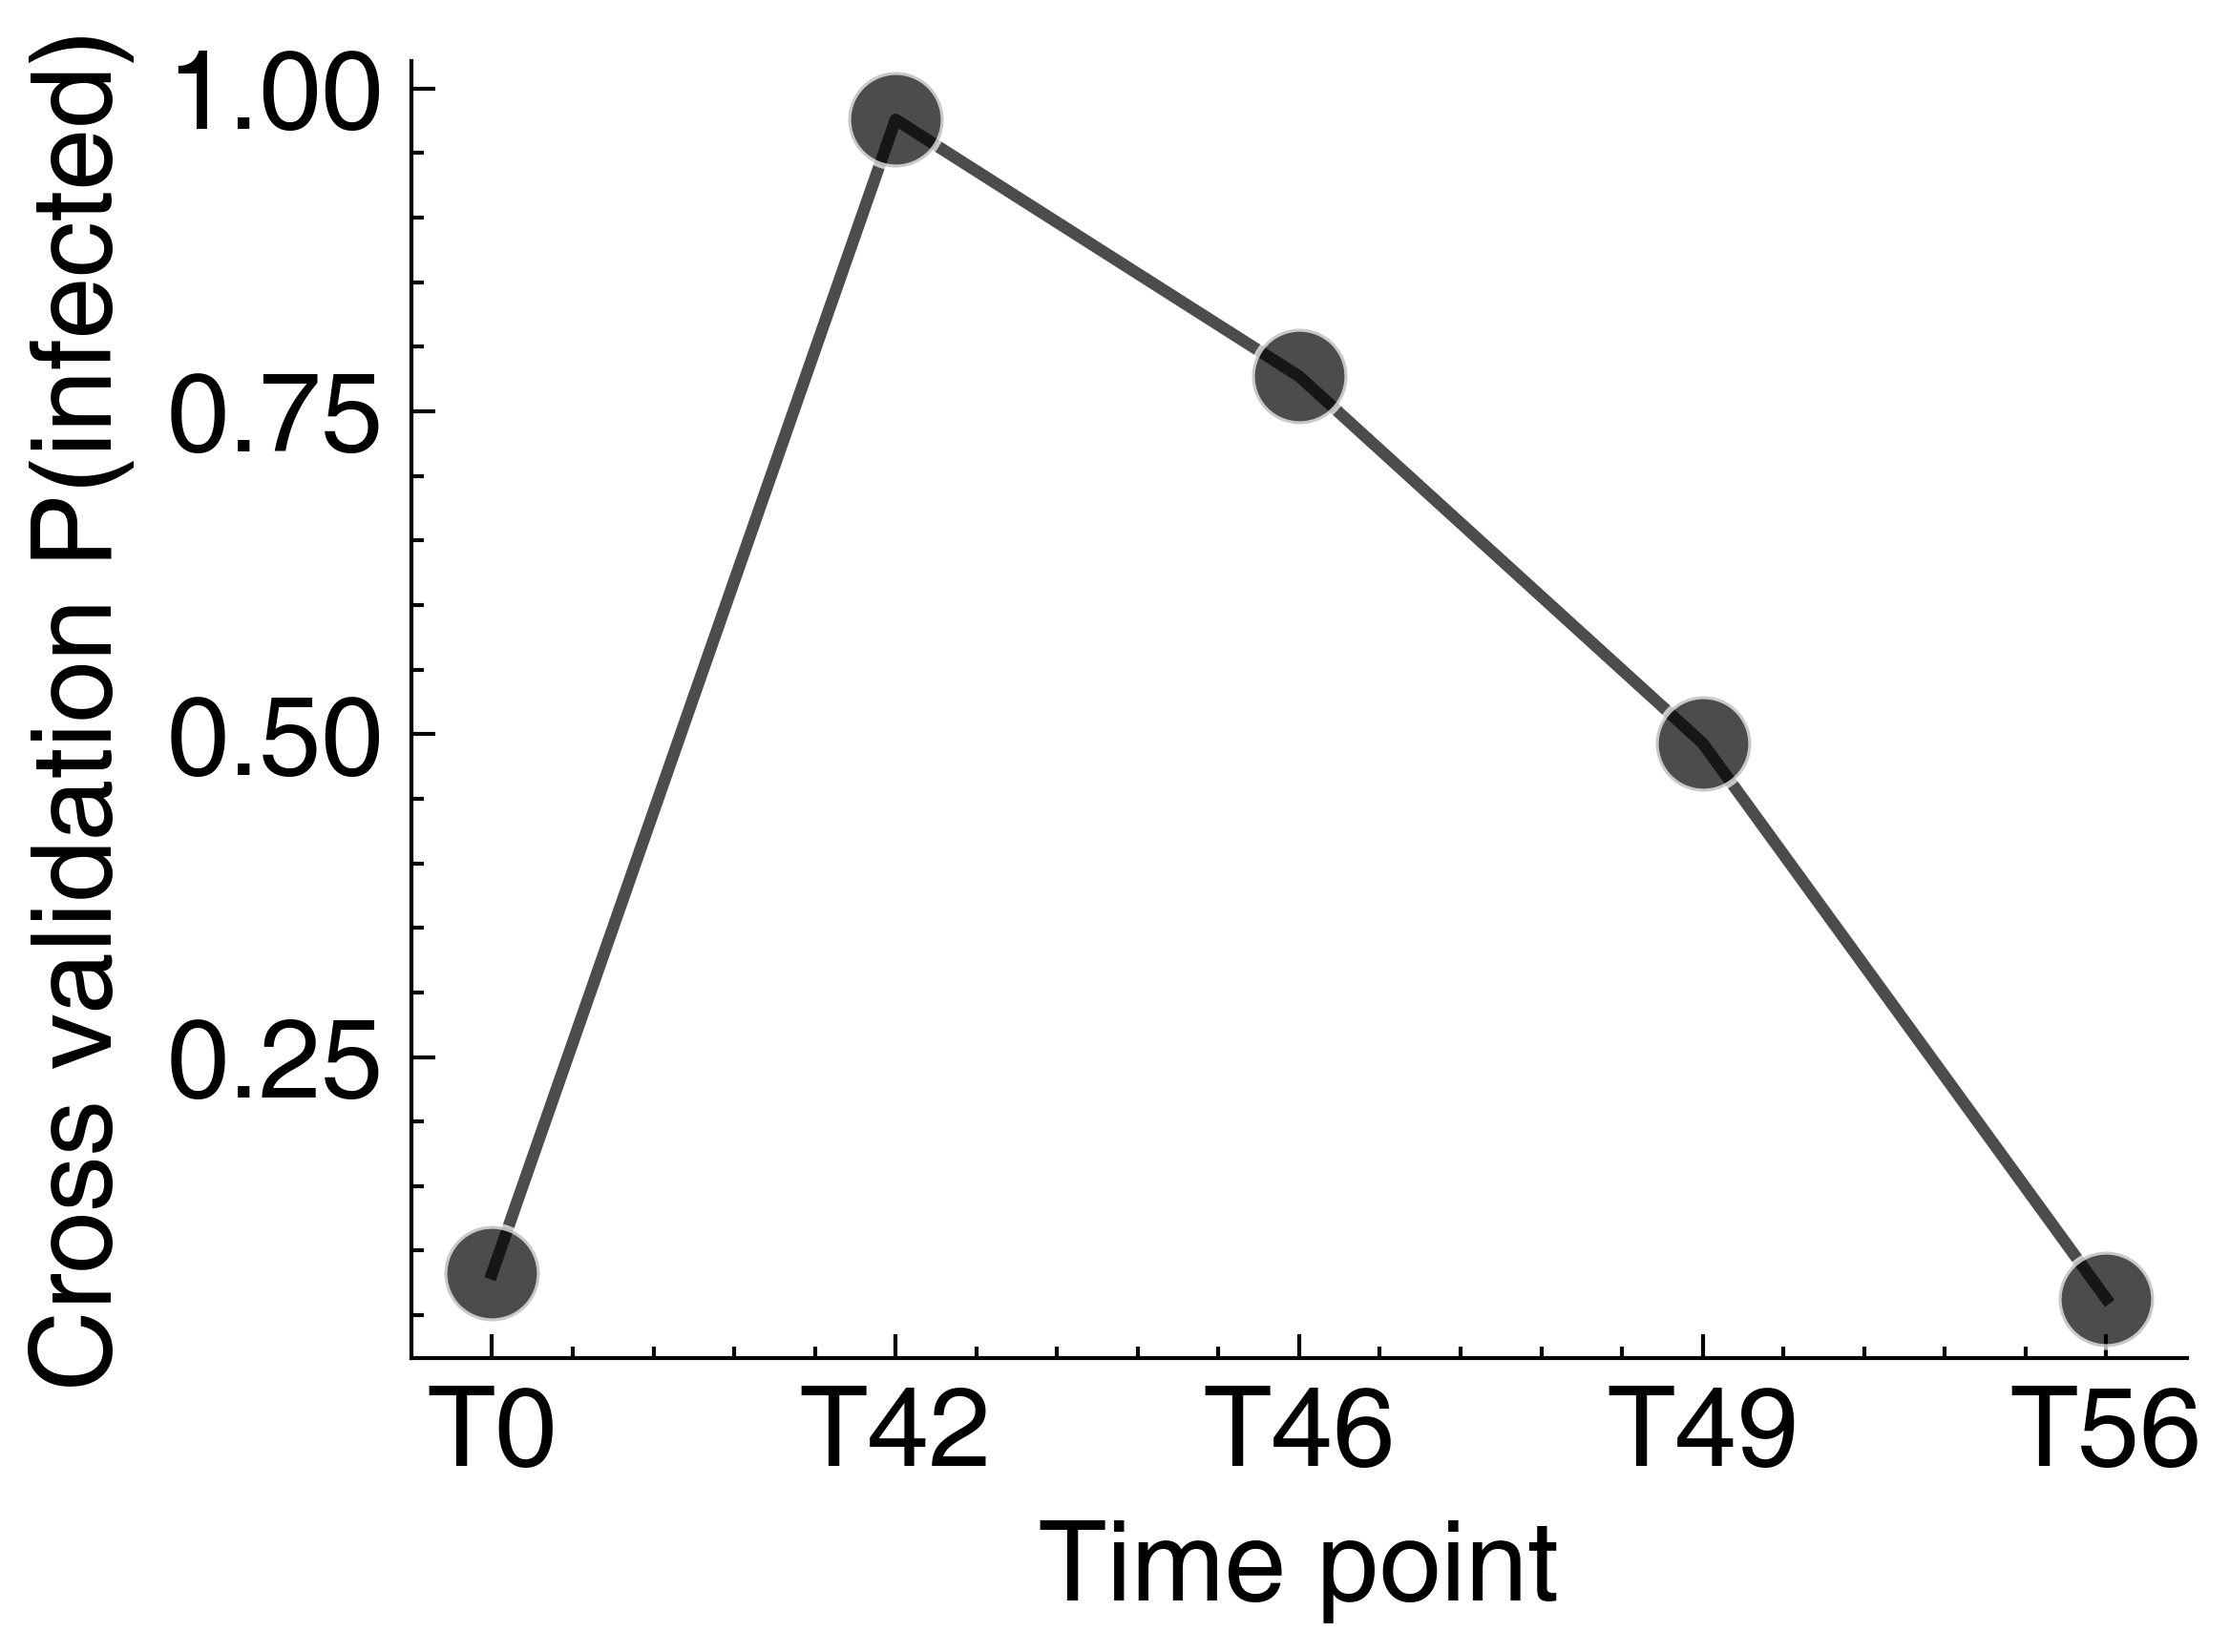

In [26]:
plot_df = best_train_df.loc[best_train_df['individual']=='P20_0593']
plot_df['individual'] = ['P%s'%x.split('_')[1] for x in plot_df['individual']]
plot_df['tp'] = ['T%i'%i for i in plot_df['tp']]
fig, ax = plt.subplots(1,1, figsize=(4,3))
sns.lineplot(x='tp', y='cv_pred', hue='individual', marker='o', ls='-',
             #order=['T0', 'T42', 'T46', 'T49', 'T56'],
             markersize=12, data=plot_df, alpha=0.7,
             ax=ax)
ax.set_ylabel('Cross validation P(infected)')
ax.set_xlabel('Time point')
handles, labels = ax.get_legend_handles_labels()
for h in handles: h.set_linestyle("-")
#ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend().remove()
fig.savefig('%s/02-train_cv_ctrl_P0593.pdf' % CLFDIR)

```R
%%R -i duke_y -i duke_pred -i CLFDIR
library(PRROC)
pr = pr.curve(as.vector(duke_pred[duke_y==1]), as.vector(duke_pred[duke_y==0]), curve=T)
pdf(file.path(CLFDIR, "02-test_aupr.pdf"), width=5, height=5)
plot(pr, main='Duke prediction AUPR')
dev.off()
plot(pr, main='Duke prediction AUPR')

pdf(file.path(CLFDIR, "02-test_auroc.pdf"), width=5, height=5)
roc = roc.curve(as.vector(duke_pred[duke_y==1]), as.vector(duke_pred[duke_y==0]), curve=T)
plot(roc, main='Duke prediction AUROC')
dev.off()
plot(roc, main='Duke prediction AUROC')
```

# 5. Comparison to Public DEG signatures

In [27]:
#gene_sigs_df = pd.DataFrame({
#    'signature_id': ['Lancet_Microbes;Li', 'BMC;Kwan'],
#    'geneSymbols': [';'.join(gene_sig1), ';'.join(gene_sig2)]
#})
#gene_sigs_df.to_csv("%s/pub_deg_sigs.txt"%CLFDIR, sep="\t", index=None)
gene_sigs_df = pd.read_csv("%s/pub_deg_sigs.txt"%CLFDIR, sep="\t", index_col=0)
gene_sigs_df['listify_genes'] = [x.split(';') for x in gene_sigs_df['geneSymbols']]

In [28]:
deg_sigs2 = pd.read_table("%s/published_COVID19_signatures.txt"%CLFDIR, sep="\t", index_col=0)
deg_sigs2['listify_genes'] = [list(set([g for g in x.split(',') if g in df1.index and g in df2.index])) for x in deg_sigs2['geneSymbols']]
gene_sigs_df2 = gene_sigs_df.append(deg_sigs2)

In [29]:
configs_pub = {
    f'{sign_id}': {
        'feature_eids': gene_sigs_df2.loc[sign_id, "listify_genes"],
        'train_conds': "final=='Control' or final=='First'",
        'model_type': 'DEG',
    }
    for sign_id in gene_sigs_df2.index
}

In [30]:
pub_evals = {}
for model_id in configs_pub:
    print(model_id)
    if model_id in pub_evals:
        continue
    clf, train_df, train_psi_df, train_stat = build_classifier(
        **configs_pub[model_id])
    duke_y, duke_pred, duke_psi_df, test_stat = build_tester(
        trained_clf=clf,
        feature_eids=configs_pub[model_id]['feature_eids'], 
        feature_df_columns=train_stat['feature_df.columns'],
        add_sex_term=configs_pub[model_id].get('add_sex_term', False),
        model_type=configs_pub[model_id].get('model_type', 'DAS')
    )
    pub_evals[model_id] = test_stat

Li_PMID34423323
Kwan_PMID34116667


/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Thair_PMID33437935


/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Aschenbrenner_PMID33441124


/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Lee_PMID32651212


/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


McClain_PMID33597532


/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
pub_evals_df = pd.DataFrame.from_dict(pub_evals, orient='index')
pub_evals_df.rename(columns={
    'n_features': 'No. Features', 
    'test_aupr': 'Test AUPR', 
    'test_auc': 'Test AUROC', 
    'feature_qval': 'FDR cutoff'}, inplace=True)


In [32]:
charm_best = pd.concat(
        [x.sort_values('Test AUROC').tail(1)[['No. Features', 'Test AUROC', 'Test AUPR']] 
         for y, x in model_eval_df.groupby('model_type')]
    )
charm_best.index = ['CHARM-DAS', 'CHARM-DEG']
charm_best

,No. Features,Test AUROC,Test AUPR
CHARM-DAS,276,0.849944,0.919025
CHARM-DEG,300,0.802912,0.907648


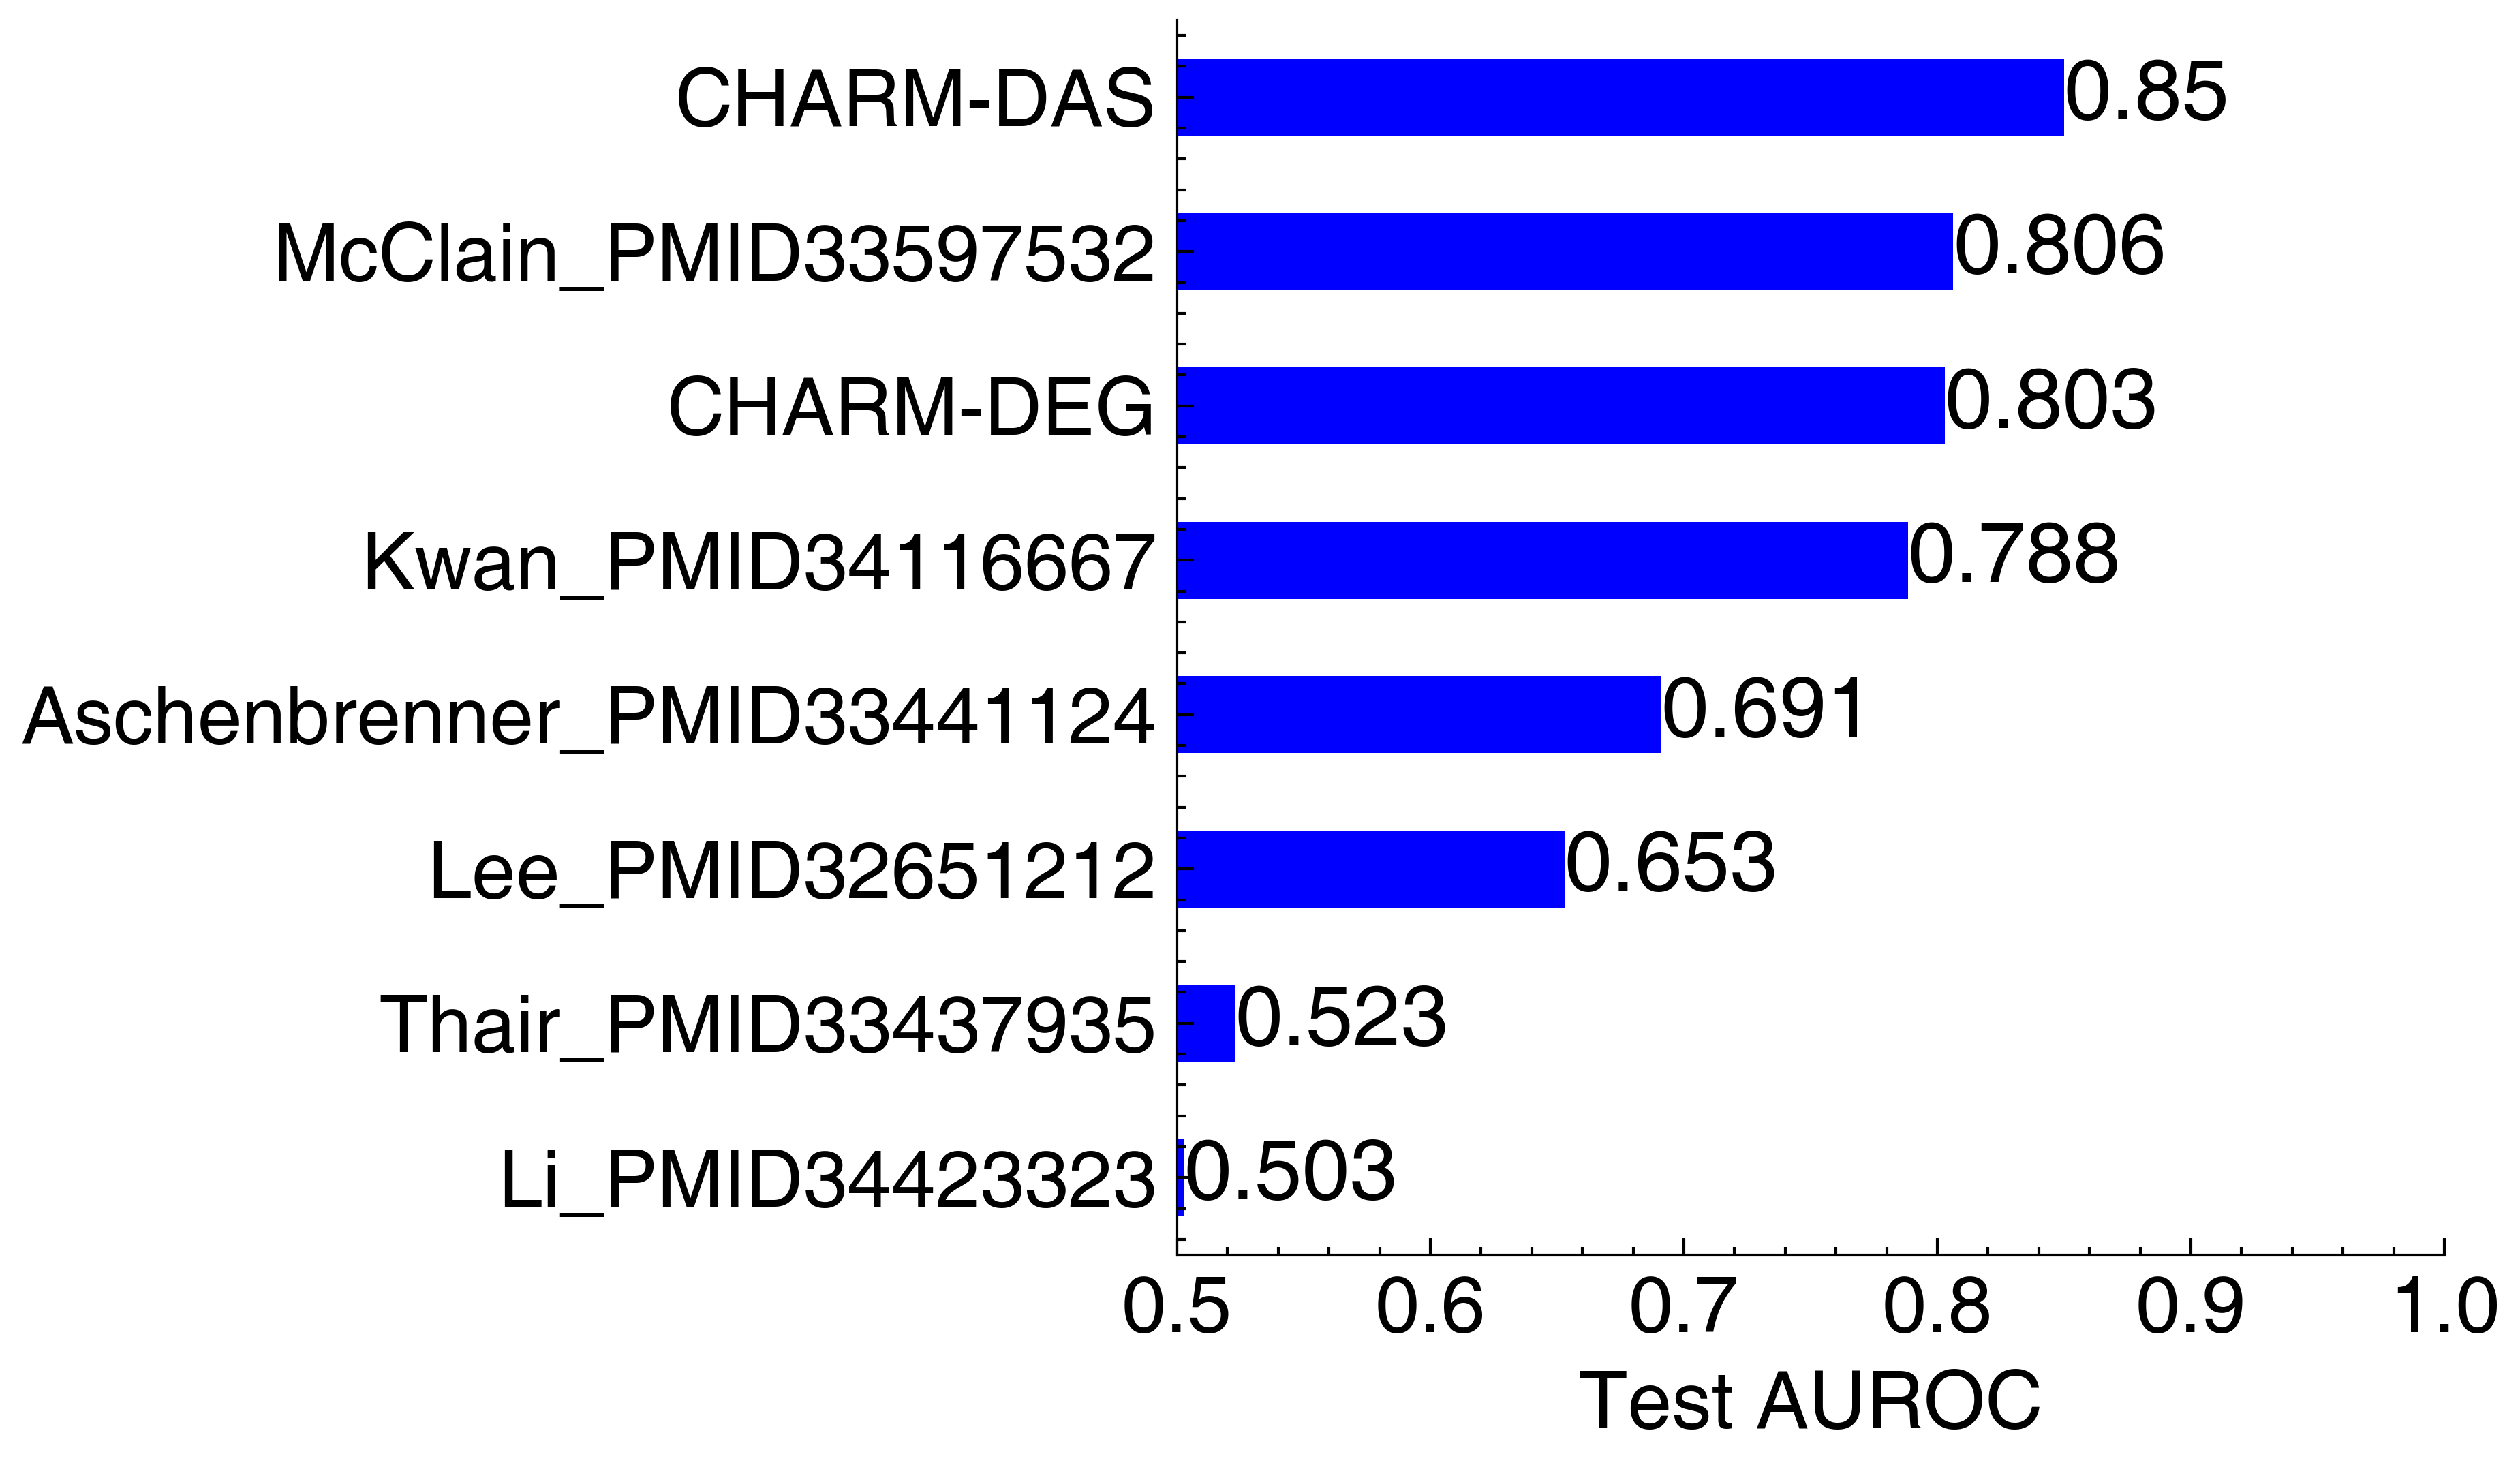

In [33]:
plot_df = pub_evals_df.append(charm_best)
plot_df['model'] = plot_df.index
plot_df['model']
ax = plot_df.sort_values('Test AUROC').plot.barh(x="model", y='Test AUROC', color="blue")
ax.legend().remove()
ax.set_xlabel('Test AUROC')
ax.set_ylabel('')
ax.set_xlim(0.5, 1)
for i, v in enumerate(plot_df.sort_values('Test AUROC')['Test AUROC']):
    ax.text(v, i, str(round(v,3)), ha='left' if v>0 else 'right', va='center', color='black', fontweight='bold',
           fontsize=15)
plt.savefig("%s/01-comparison-to-public.pdf"%CLFDIR)

In [34]:
plot_df

,No. Features,Test AUPR,Test AUROC,model
Li_PMID34423323,3,0.743910,0.502800,Li_PMID34423323
Kwan_PMID34116667,129,0.893065,0.788354,Kwan_PMID34116667
Thair_PMID33437935,413,0.747118,0.522956,Thair_PMID33437935
Aschenbrenner_PMID33441124,2268,0.878299,0.690929,Aschenbrenner_PMID33441124
Lee_PMID32651212,165,0.864074,0.652856,Lee_PMID32651212
McClain_PMID33597532,13,0.888586,0.806271,McClain_PMID33597532
CHARM-DAS,276,0.919025,0.849944,CHARM-DAS
CHARM-DEG,300,0.907648,0.802912,CHARM-DEG


In [35]:
print(duke_y)
duke_pred.round(2)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


array([1.  , 1.  , 1.  , 0.38, 0.48, 0.83, 0.77, 0.46, 0.59, 0.63, 0.29,
       0.43, 0.52, 0.56, 0.48, 0.43, 0.52, 0.45, 0.23, 0.68, 0.38, 0.57,
       0.39, 0.63, 0.27, 0.87, 0.48, 0.42, 0.33, 0.39, 0.83, 0.42, 0.41,
       0.43, 1.  , 0.34, 0.59, 1.  , 0.55, 0.98, 0.57, 0.92, 0.47, 1.  ,
       1.  , 1.  , 1.  , 0.15, 0.22, 0.16, 0.55, 0.85, 0.39, 1.  , 0.32,
       0.28, 0.25, 0.48, 0.07, 0.26, 0.09, 0.21, 0.43, 0.37, 0.52, 0.03])

Skipped the calibration step below:

```python
from sklearn.calibration import calibration_curve
ax = sns.scatterplot(*calibration_curve(
    y_true=duke_pred_df['Pathogen']=="COVID-19", 
    #y_prob=duke_pred_df['FirstExon0.0001-FirstSamps'],
    y_prob=duke_pred_df['CHARM-top400'],
    n_bins=15
)
)
ax.set_xlim(-0.05,1.05)
ax.set_ylim(-0.05,1.05)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', color='grey')
ax.set_xlabel('Prob. True')
ax.set_xlabel('Prob. Pred')
```

Text(0.5, 0, 'Sex')

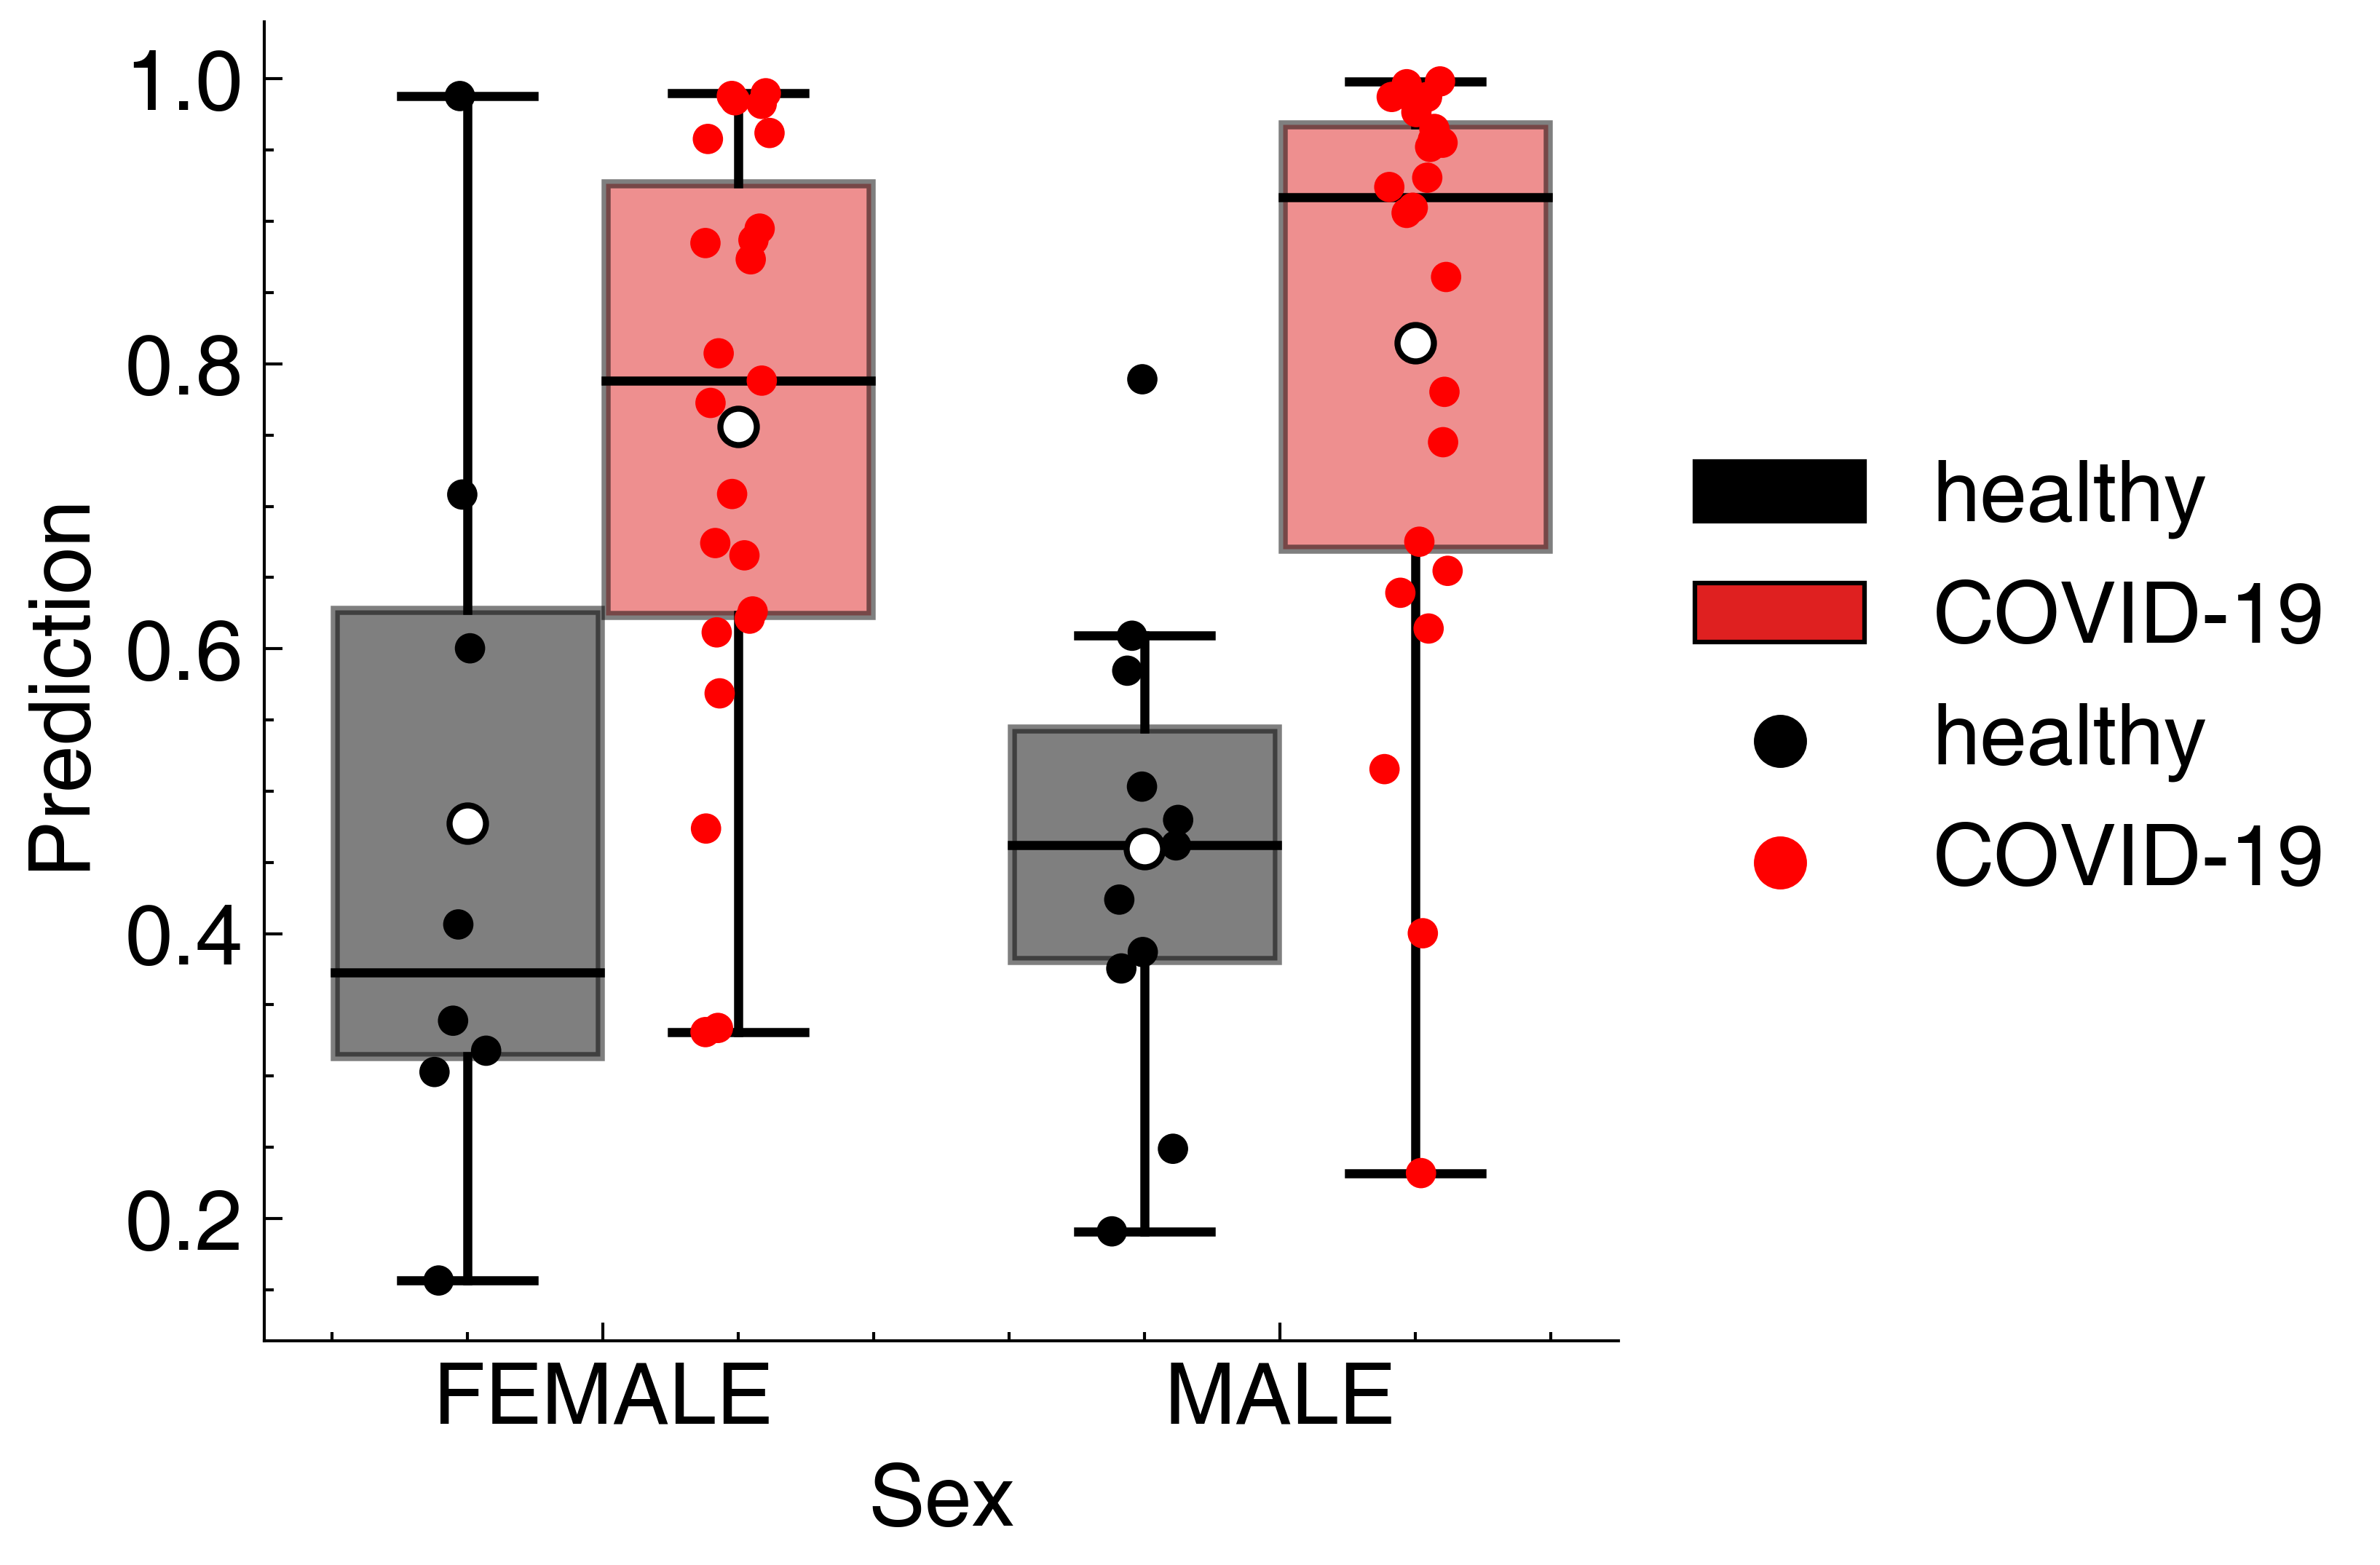

In [36]:
duke_pred_df = pd.concat(
    [pd.Series(data=duke_preds[x], index=duke_metaloader.data['SE'].covariates.covariate.index, name=x) 
     for x in duke_preds] + 
     [duke_metaloader.data['SE'].covariates.meta.loc[duke_metaloader.data['SE'].covariates.covariate.index]],
    axis=1)

fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.boxplot(y=best_clf_id, x='gender', 
            hue='Pathogen', 
            order=['FEMALE', 'MALE'],
            hue_order=['healthy', 'COVID-19'],
            showmeans=True, meanprops={"marker": 'o', "markerfacecolor":"white", "markeredgecolor": "black"},
            showfliers=False, boxprops=dict(alpha=0.5),
            ax=ax,
            data=duke_pred_df)
sns.stripplot(y=best_clf_id, x='gender',
              hue='Pathogen', 
              order=['FEMALE', 'MALE'],
              hue_order=['healthy', 'COVID-19'],
              data=duke_pred_df, ax=ax, dodge=True, edgecolor='black')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Prediction')
ax.set_xlabel('Sex')

In [37]:
def plot_eid_btw_duke_and_charm(eid, feature_psi_df, duke_psi_df, ax=None, do_plot=True):
    #print(eid)
    navy_first = feature_psi_df[[eid]].copy()
    navy_first.at[navy_first.index.isin(covs.meta.index[covs.meta.final.isin(['Control'])]), 'COVID'] = 'Control'
    navy_first.at[navy_first.index.isin(covs.meta.index[covs.meta.final.isin(['First'])]), 'COVID'] = 'COVID'
    navy_first['Cohort'] = 'Charm'
    duke_plot_df = duke_psi_df[[eid]].copy()
    duke_plot_df['COVID'] = duke_y
    duke_plot_df.at[duke_y==1, 'COVID'] = 'COVID'
    duke_plot_df.at[duke_y==0, 'COVID'] = 'Control'

    duke_plot_df['Cohort'] = 'Duke'

    duke_plot_df = navy_first.append(duke_plot_df)
    genename = metaloader._reg_tables[eid.split(':')[1]].loc[ ':'.join(eid.split(':')[2:]),  'geneSymbol' ]
    if do_plot is True:
        if ax is None:
            fig, ax = plt.subplots(1,1, figsize=(5,4))
        ax = sns.boxplot(x='Cohort', y=eid, hue='COVID', data=duke_plot_df, ax=ax, showfliers=False, boxprops=dict(alpha=0.5))
        sns.stripplot(x='Cohort', y=eid, hue='COVID', data=duke_plot_df, ax=ax, dodge=True, edgecolor='black')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_ylabel('')
        ax.set_title( ':'.join(eid.split(':')[2:]))
        fig.suptitle("%s, %s" % (
            genename,
            eid.split(':')[1]
        )
        )
        #fig.tight_layout()
    avg_psi = {}
    avg_psi['charm.ctrl'] = duke_plot_df.query('Cohort=="Charm" and COVID=="Control"')[eid].mean()
    avg_psi['charm.covid'] = duke_plot_df.query('Cohort=="Charm" and COVID!="Control"')[eid].mean()
    avg_psi['duke.ctrl'] = duke_plot_df.query('Cohort=="Duke" and COVID=="Control"')[eid].mean()
    avg_psi['duke.covid'] = duke_plot_df.query('Cohort=="Duke" and COVID!="Control"')[eid].mean()
    return ax, genename, avg_psi

In [38]:
best_train_stats = train_stats[best_clf_id]
best_coefs_abs = best_train_stats['clf.coef'].abs()
feature_psi_df = train_psi_dfs[best_clf_id]
duke_psi_df = duke_psi_dfs[best_clf_id]

In [39]:
# write out all consistent events
best_coefs_abs_ = best_train_stats['clf.coef'].abs().sort_values(ascending=False)
best_coefs = best_train_stats['clf.coef']
cross_cohort_evts = pd.DataFrame(columns=['event_id', 'event_type', 'genename', 'importance', 'charm.ctrl',
                                         'charm.covid',
                                          'duke.ctrl', 'duke.covid'
                                         ])

for eid in best_coefs_abs_.index:
    _, genename, avg_psi = plot_eid_btw_duke_and_charm(eid, feature_psi_df, duke_psi_df, do_plot=False)
    this = {
            'event_id': ":".join(eid.split(':')[2:]),
            'event_type': eid.split(':')[1],
            'genename': genename,
            'importance': best_coefs[eid],
        }
    this.update(avg_psi)
    cross_cohort_evts = cross_cohort_evts.append(
        this, ignore_index=True
    )

cross_cohort_evts['abs_importance'] = cross_cohort_evts['importance'].abs()
cross_cohort_evts['charm.delta'] = cross_cohort_evts['charm.covid'] - cross_cohort_evts['charm.ctrl']
cross_cohort_evts['duke.delta'] = cross_cohort_evts['duke.covid'] - cross_cohort_evts['duke.ctrl']
cross_cohort_evts['is_consistent'] = np.sign(cross_cohort_evts['charm.delta'] * 
    cross_cohort_evts['duke.delta'] )
cross_cohort_evts = cross_cohort_evts.dropna()

In [40]:
cross_cohort_evts_1pct = cross_cohort_evts.loc[(cross_cohort_evts['charm.delta'].abs()>0.01) & (cross_cohort_evts['is_consistent']==1)]
cross_cohort_evts_1pct.rename(columns={
    'charm.ctrl': 'Charm control PSI',
    'charm.covid': 'Charm covid PSI',
    'duke.ctrl': 'Duke control PSI',
    'duke.covid': 'Duke covid PSI',
    'charm.delta': 'Charm delta PSI',
    'duke.delta': 'Duke delta PSI',
}, inplace=True)
cross_cohort_evts_1pct.drop(columns=['is_consistent', 'abs_importance'], inplace=True)
cross_cohort_evts_1pct.to_csv('%s/das_classifier/06-cross_cohort_evts_1pct.tsv' % DATA_VER, index=False, sep="\t")
cross_cohort_evts_1pct

/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,event_id,event_type,genename,importance,Charm control PSI,Charm covid PSI,Duke control PSI,Duke covid PSI,Charm delta PSI,Duke delta PSI
0,chr13:-:42917624:42919299:42919332:42926335,SE,EPSTI1,1.338842,0.410087,0.475345,0.515139,0.598682,0.065258,0.083543
1,chr22:+:22888259:22893699:22893818:22895374,SE,IGLL5,1.336250,0.744223,0.810055,0.870451,0.907653,0.065831,0.037201
2,chr6:+:31587199:31587318:31588517:31588909,RI,LST1,-1.270864,0.526558,0.479969,0.612048,0.451003,-0.046589,-0.161045
4,chr16:-:16219947:16220272:16220388:16221648,SE,ABCC6,-1.074491,0.732908,0.659868,0.664114,0.534855,-0.073040,-0.129259
11,chr20:+:5127149:5173522:5173659:5175182,SE,CDS2,-0.859815,0.826068,0.798928,0.821880,0.767656,-0.027140,-0.054224
...,...,...,...,...,...,...,...,...,...,...
237,chr7:+:102433661:102436201:102433661:102436229,A3SS,ORAI2,-0.042246,0.036010,0.049806,0.023873,0.034385,0.013796,0.010512
240,chr21:+:41426263:41427205:41427304:41427754,SE,MX1,0.038041,0.869087,0.882870,0.838623,0.891971,0.013783,0.053348
261,chr14:-:94388663:94388800:94389010:94390456,SE,SERPINA1,-0.019957,0.489709,0.506599,0.452662,0.491341,0.016890,0.038678
266,chr16:-:31201841:31202146:31202203:31202416,SE,PYCARD,-0.012346,0.907374,0.892486,0.899671,0.889576,-0.014888,-0.010095


In [41]:
print("FINISH:", datetime.now())

FINISH: 2022-07-02 17:22:11.706409
